# Self driving car - street lane tracing 
the goal of this work is to design RC robotic car , this car is supposed to trace the lanes on a small track. 

In [42]:
import pandas as pd
import os 
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
from skimage import io
import torchvision.transforms as transforms
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from math import floor , ceil
import torch.nn as nn
import torch.optim as optim
from model import self_driving_model
from tqdm import tqdm

In [43]:
class customDataset(Dataset):
  def __init__(self,csv_file,root_url,transform = None):
    self.annotation = pd.read_csv(csv_file)
    self.root_dir = root_url
    self.transform = transform

  def __len__(self):
    return len(self.annotation)

  def __getitem__(self, index):
    image_path = os.path.join(self.root_dir,self.annotation.iloc[index,0].split(';')[0])
    image = io.imread(image_path)
    y_label = torch.tensor(int(self.annotation.iloc[index,0].split(';')[1][1]))
    if self.transform :
      image = self.transform(image)
    return (image,y_label)

In [44]:
data_set = customDataset(csv_file = 'drive/MyDrive/dataset/ref/ref.csv',root_url='drive/MyDrive/dataset/images'
,transform = transforms.ToTensor())

train_to_test_ratio = 0.8

data_length = data_set.__len__()
train_data_length = floor(data_length*train_to_test_ratio)
test_data_length = ceil(data_length*(1 - train_to_test_ratio))

train_set , test_set = torch.utils.data.random_split(data_set , [train_data_length , test_data_length])


batch_size = 32


train_loader = DataLoader(dataset = train_set , batch_size = batch_size , shuffle = True)
test_loader = DataLoader(dataset = test_set , batch_size = batch_size , shuffle = True)
print('training data size is :',train_data_length)
print('testing data size is :',test_data_length)

training data size is : 8909
testing data size is : 2228


In [61]:
LR = 0.001
num_epochs = 25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [62]:
num_classes = 4
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, num_classes)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('number of parameters in the model : ',pytorch_total_params)
model = model.to(device)

number of parameters in the model :  11178564


In [63]:
class_weights= torch.tensor([1.0,10.0,1.0,10.0]).to(device = device)

In [64]:
criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
optimizer = optim.Adam(model.parameters(),lr = LR)

after running the next ceil the training will start

In [65]:
loss_trace = []
for epoch in range(num_epochs):
  losses = []
  for batch_idx, (data,targets) in tqdm(enumerate(train_loader)):
    data = data.to(device = device)
    targets = targets.to(device = device)

    scores = model(data)
    loss = criterion(scores, targets)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  print(f'cost at epoch {epoch} , is {sum(losses)/len(losses)}')
  loss_trace.append(sum(losses)/len(losses))

279it [03:51,  1.20it/s]


cost at epoch 0 , is 0.5557560176191364


279it [03:52,  1.20it/s]


cost at epoch 1 , is 0.4928936456266697


279it [03:52,  1.20it/s]


cost at epoch 2 , is 0.4906942358901424


279it [03:52,  1.20it/s]


cost at epoch 3 , is 0.4789094500323778


279it [03:52,  1.20it/s]


cost at epoch 4 , is 0.48484629296487375


279it [03:52,  1.20it/s]


cost at epoch 5 , is 0.46328026504926784


279it [03:52,  1.20it/s]


cost at epoch 6 , is 0.46856460503993497


279it [03:52,  1.20it/s]


cost at epoch 7 , is 0.46046858005839864


279it [03:52,  1.20it/s]


cost at epoch 8 , is 0.44936851441432923


279it [03:52,  1.20it/s]


cost at epoch 9 , is 0.46433252875950176


279it [03:52,  1.20it/s]


cost at epoch 10 , is 0.4547135029856022


279it [03:52,  1.20it/s]


cost at epoch 11 , is 0.4355747526157714


279it [03:52,  1.20it/s]


cost at epoch 12 , is 0.4263715758973125


279it [03:52,  1.20it/s]


cost at epoch 13 , is 0.4134756764096598


279it [03:52,  1.20it/s]


cost at epoch 14 , is 0.40042081464576035


279it [03:52,  1.20it/s]


cost at epoch 15 , is 0.3765549164625906


279it [03:52,  1.20it/s]


cost at epoch 16 , is 0.3328606085217555


279it [03:52,  1.20it/s]


cost at epoch 17 , is 0.2759651756948895


279it [03:52,  1.20it/s]


cost at epoch 18 , is 0.23375971499149517


279it [03:52,  1.20it/s]


cost at epoch 19 , is 0.18019382838547016


279it [03:52,  1.20it/s]


cost at epoch 20 , is 0.13449467814070135


279it [03:52,  1.20it/s]


cost at epoch 21 , is 0.08050770996685898


279it [03:52,  1.20it/s]


cost at epoch 22 , is 0.09372006513438719


279it [03:52,  1.20it/s]


cost at epoch 23 , is 0.06295030267815703


279it [03:52,  1.20it/s]

cost at epoch 24 , is 0.027769224119446104


shows the loss vs epochs plot

Text(0, 0.5, 'loss')

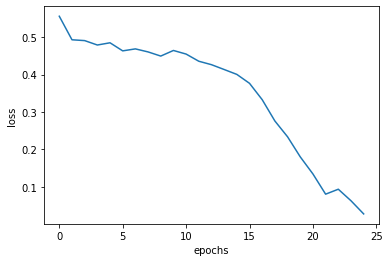

In [66]:
plt.plot(loss_trace)
plt.xlabel('epochs')
plt.ylabel('loss')

In [67]:
def check_accuracy(loader , model):
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for x,y in tqdm(loader) :
      x = x.to(device = device)
      y = y.to(device = device)

      scores = model(x)
      predicions = torch.argmax(scores,dim = 1)
      num_correct += (predicions == y).sum()
      num_samples += predicions.size(0)
    print(f'got {num_correct}/{num_samples} with accuracy {(float(num_correct)/float(num_samples))*100.0}')
  model.train()


In [68]:
print('checking accuracy on training set')
check_accuracy(train_loader , model)

print('checking accuracy on testing set')
check_accuracy(test_loader , model)

checking accuracy on training set


100%|██████████| 279/279 [01:05<00:00,  4.28it/s]


got 8810/8909 with accuracy 98.88876417106297
checking accuracy on testing set


100%|██████████| 70/70 [00:16<00:00,  4.31it/s]


got 1775/2228 with accuracy 79.66786355475763


finally save the model

In [60]:
path = ''
torch.save(model.state_dict(),os.path.join(path,'mod.stat'))